# One hot encoding + Fully connected nn

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv('feedback_lema.csv')
df = df[['lemmatized_review', 'rating', 'mood']]
df.mood = df.mood.replace(22, 2)
df['mood'] = df['mood'].replace({0: 'negative', 1: 'neutral', 2: 'positive'})
df.rename(columns={'lemmatized_review': 'text'}, inplace=True)
df.head()

,text,rating,mood
0,"вообщий комод за такой цена норма , весь детал...",5,positive
1,"комод просто замечательный,очень легко и удоб...",5,positive
2,к сожаление разочарование. во первый не полага...,1,negative
3,"за свой деньги хороший товар. собирать быстро,...",5,positive
4,"комод хороший я понравиться , приходить целый ...",5,positive


In [3]:
df = df[['text', 'mood']]
df['mood'] = df['mood'].replace({0: 'negative', 1: 'neutral', 2: 'positive'})
texts = df['text'].values
mood_map = {'negative': 0, 'neutral': 1, 'positive': 2}
labels = df['mood'].map(mood_map).values  # Числовые метки для модели
df.head()


,text,mood
0,"вообщий комод за такой цена норма , весь детал...",positive
1,"комод просто замечательный,очень легко и удоб...",positive
2,к сожаление разочарование. во первый не полага...,negative
3,"за свой деньги хороший товар. собирать быстро,...",positive
4,"комод хороший я понравиться , приходить целый ...",positive


In [4]:
print(df['mood'].value_counts())  # Убедитесь, что все метки корректны


mood
positive    6092
negative    2072
neutral      512
Name: count, dtype: int64


Определяем параметры: максимальное количество слов и максимальную длину текста.
Создаем токенизатор и обучаем его на текстах отзывов.
Преобразуем тексты в последовательности токенов (чисел).
Паддим (дополняем или обрезаем) эти последовательности до одинаковой длины.
Преобразуем метки настроения в массив.

In [5]:
# Параметры
max_words = 10000  # Размер словаря (максимум 10,000 слов)
max_length = 200  # Длина текстов (обрезка/паддинг до 200 токенов)


In [6]:
# Создаем токенизатор и преобразуем тексты в последовательности токенов
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [7]:
# Паддинг последовательностей до одинаковой длины
x = pad_sequences(sequences, maxlen=max_length)

# Преобразуем метки в формат one-hot encoding
y = np.array(labels)

In [8]:
# Разделяем данные на обучающий (70%), валидационный (20%) и тестовый (10%) наборы
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(1/3), random_state=42)

Здесь мы создаем простую нейронную сеть с:

Входным слоем (128 нейронов) с функцией активации ReLU.
Скрытым слоем (64 нейрона) с функцией активации ReLU.
Выходным слоем (3 нейрона) с функцией активации softmax (для классификации на 3 класса).

In [9]:
# Создаем модель нейронной сети
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(max_length,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 класса: negative, neutral, positive


In [10]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Используем sparse_categorical_crossentropy для многоклассовой классификации
              metrics=['accuracy'])

Обучаем модель на обучающих данных, используя:

10 эпох (полнокругов обучения на всех данных).
Размер батча 128 (количество примеров, используемых для одного обновления параметров модели).
20% данных для тестового набора.

In [11]:
# обучение модели
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/10
48/48 [==============================] - 3s 13ms/step - loss: 59.8845 - accuracy: 0.5366 - val_loss: 37.9013 - val_accuracy: 0.5331
Epoch 2/10
48/48 [==============================] - 0s 8ms/step - loss: 21.1496 - accuracy: 0.5844 - val_loss: 28.2635 - val_accuracy: 0.6150
Epoch 3/10
48/48 [==============================] - 0s 7ms/step - loss: 13.4435 - accuracy: 0.6237 - val_loss: 26.3939 - val_accuracy: 0.6277
Epoch 4/10
48/48 [==============================] - 0s 6ms/step - loss: 10.1199 - accuracy: 0.6391 - val_loss: 23.3708 - val_accuracy: 0.6305
Epoch 5/10
48/48 [==============================] - 0s 7ms/step - loss: 7.7082 - accuracy: 0.6666 - val_loss: 20.1249 - val_accuracy: 0.5591
Epoch 6/10
48/48 [==============================] - 0s 7ms/step - loss: 6.2724 - accuracy: 0.6809 - val_loss: 18.8155 - val_accuracy: 0.6069
Epoch 7/10
48/48 [==============================] - 0s 8ms/step - loss: 5.2137 - accuracy: 0.6817 - val_loss: 18.7191 - val_accuracy: 0.5821
Epoch 8/

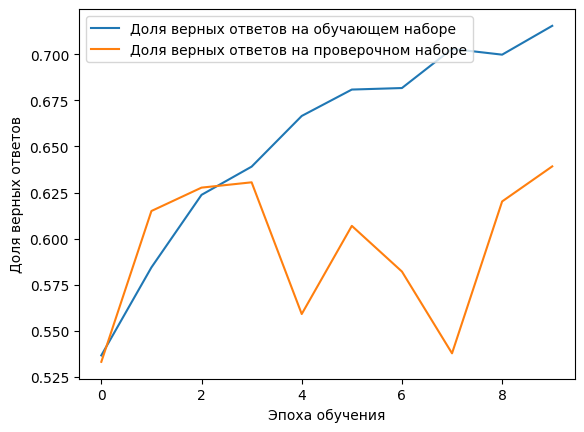

In [12]:
# Визуализируем процесс обучения
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [13]:
# Проверяем работу сети на тестовом наборе данных
scores = model.evaluate(x_test, y_test, verbose=1)

print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 2))

28/28 [==============================] - 0s 5ms/step - loss: 13.9085 - accuracy: 0.6740
Доля верных ответов на тестовых данных, в процентах: 67.4


# Embedding + Fully connected nn

Embedding слой: Преобразует каждый токен в вектор из 50 измерений. Это помогает модели понять смысл слов.

Dropout слой: Отключает случайные нейроны с вероятностью 25% на каждой итерации обучения для предотвращения переобучения.

Flatten слой: Преобразует данные из двумерного в одномерный массив.

Dense слой: Полносвязный слой с 128 нейронами и функцией активации ReLU (Rectified Linear Unit), которая делает выход нелинейным.

Dense слой: Полносвязный слой с 64 нейронами и функцией активации ReLU.

Dense слой: Выходной слой с 3 нейронами (по одному для каждого класса настроений) и функцией активации softmax для получения вероятностей каждого класса.

In [14]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
# Создаем модель нейронной сети
maxlen = 200  # Длина текстов (обрезка/паддинг до 200 токенов)
model = Sequential()
model.add(Embedding(max_words, 50, input_length=maxlen))  # Используем 50 размерность для эмбеддингов
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # Добавляем полносвязный слой с 128 нейронами
model.add(Dense(64, activation='relu'))  # Добавляем полносвязный слой с 64 нейронами
model.add(Dense(3, activation='softmax'))  # 3 класса: negative, neutral, positive


In [15]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Используем sparse_categorical_crossentropy для многоклассовой классификации
              metrics=['accuracy'])

# Обучаем модель
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(x_val, y_val)
                    )



Epoch 1/15
48/48 [==============================] - 16s 261ms/step - loss: 0.7621 - accuracy: 0.6955 - val_loss: 0.7481 - val_accuracy: 0.6870
Epoch 2/15
48/48 [==============================] - 7s 150ms/step - loss: 0.5517 - accuracy: 0.7805 - val_loss: 0.4824 - val_accuracy: 0.8231
Epoch 3/15
48/48 [==============================] - 6s 136ms/step - loss: 0.3549 - accuracy: 0.8763 - val_loss: 0.4510 - val_accuracy: 0.8300
Epoch 4/15
48/48 [==============================] - 4s 79ms/step - loss: 0.2555 - accuracy: 0.9089 - val_loss: 0.4422 - val_accuracy: 0.8507
Epoch 5/15
48/48 [==============================] - 4s 73ms/step - loss: 0.1902 - accuracy: 0.9307 - val_loss: 0.4739 - val_accuracy: 0.8386
Epoch 6/15
48/48 [==============================] - 5s 99ms/step - loss: 0.1410 - accuracy: 0.9514 - val_loss: 0.5145 - val_accuracy: 0.8357
Epoch 7/15
48/48 [==============================] - 2s 45ms/step - loss: 0.1130 - accuracy: 0.9638 - val_loss: 0.5232 - val_accuracy: 0.8421
Epoch 8/1

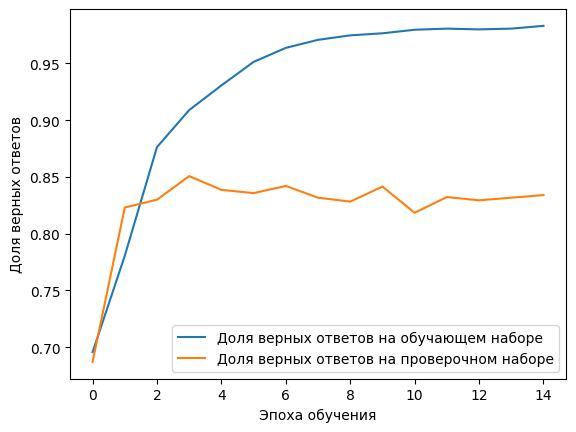

In [16]:
# Визуализируем процесс обучения
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [17]:
# Проверяем работу сети на тестовом наборе данных
scores = model.evaluate(x_test, y_test, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 2))

28/28 [==============================] - 0s 3ms/step - loss: 0.7675 - accuracy: 0.8329
Доля верных ответов на тестовых данных, в процентах: 83.29


In [18]:
y_pred = model.predict(x_test)
y_pred

28/28 [==============================] - 0s 2ms/step


array([[9.5083698e-04, 1.1154789e-03, 9.9793375e-01],
       [9.9965739e-01, 2.8967950e-04, 5.2909636e-05],
       [7.6690620e-01, 5.3947039e-02, 1.7914674e-01],
       ...,
       [3.3367712e-02, 3.4729186e-02, 9.3190312e-01],
       [3.4975176e-04, 5.8324602e-03, 9.9381775e-01],
       [9.9875212e-01, 5.5824564e-04, 6.8959710e-04]], dtype=float32)

In [19]:
# Преобразуем вероятности в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразуем числовые метки обратно в текстовые
mood_map_inv = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_texts = [mood_map_inv[label] for label in y_pred_classes]
y_test_texts = [mood_map_inv[label] for label in y_test]

In [20]:
y_test_texts

['positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'p

In [21]:
# Добавьте предсказания в исходный DataFrame как новый столбец
df_test = pd.DataFrame({
    'Text': texts[-len(x_test):],  # Берем тексты из последней части исходного списка
    'True Label': y_test_texts,
    'Predicted Label': y_pred_texts
})

# Найдите неправильные предсказания
incorrect_df_fcnn = df_test[df_test['True Label'] != df_test['Predicted Label']]

# Сохраните DataFrame с неправильными предсказаниями в CSV файл для дальнейшего анализа
incorrect_df_fcnn.to_csv('incorrect_predictions.csv', index=False)

In [22]:
incorrect_df_fcnn.head()

,Text,True Label,Predicted Label
8,очень хороший👍👍\n,negative,positive
12,"приходить целый, тяжелый\n",negative,neutral
18,"деталь не сходиться в сборка , неправильно быт...",negative,positive
28,неплохой комод. только приходиться сверлить но...,negative,positive
43,все отлично\n,positive,negative


# RNN

Embedding(max_words, 50, input_length=max_length)
Этот слой представляет слова (или токены) в виде векторов заданной размерности (здесь 50) и принимает входные данные длиной max_length.
SimpleRNN Layer (Слой SimpleRNN):

SimpleRNN(16, activation='relu')
SimpleRNN (Простая Рекуррентная Нейронная Сеть) с 16 нейронами и функцией активации ReLU. Этот слой позволяет модели учитывать последовательность данных, сохраняя состояние (память) между шагами.
Output Layer (Выходной слой):

Dense(3, activation='softmax')
Выходной слой с 3 нейронами и функцией активации softmax для предсказания вероятностей принадлежности к каждому из трёх классов: negative, neutral и positive.

In [23]:
from tensorflow.keras.layers import SimpleRNN

# Создаем модель нейронной сети
model = Sequential()
model.add(Embedding(max_words, 50, input_length=max_length))  # Увеличим размерность эмбеддинга до 50
model.add(SimpleRNN(16, activation='relu'))  # Увеличим количество нейронов в RNN до 16
model.add(Dense(3, activation='softmax'))  # 3 класса: negative, neutral, positive

# Компилируем модель
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',  # Используем sparse_categorical_crossentropy для многоклассовой классификации
              metrics=['accuracy'])

Epoch 1/10
48/48 [==============================] - 16s 308ms/step - loss: 0.9293 - accuracy: 0.6862 - val_loss: 0.7916 - val_accuracy: 0.6888
Epoch 2/10
48/48 [==============================] - 13s 271ms/step - loss: 0.6606 - accuracy: 0.7090 - val_loss: 0.6114 - val_accuracy: 0.7084
Epoch 3/10
48/48 [==============================] - 12s 258ms/step - loss: 0.5125 - accuracy: 0.7998 - val_loss: 0.5341 - val_accuracy: 0.7804
Epoch 4/10
48/48 [==============================] - 14s 296ms/step - loss: 0.4319 - accuracy: 0.8492 - val_loss: 0.4838 - val_accuracy: 0.8357
Epoch 5/10
48/48 [==============================] - 13s 264ms/step - loss: 0.3741 - accuracy: 0.8749 - val_loss: 0.4698 - val_accuracy: 0.8317
Epoch 6/10
48/48 [==============================] - 11s 232ms/step - loss: 0.3162 - accuracy: 0.8946 - val_loss: 0.4321 - val_accuracy: 0.8473
Epoch 7/10
48/48 [==============================] - 11s 225ms/step - loss: 0.2849 - accuracy: 0.9050 - val_loss: 0.4319 - val_accuracy: 0.8513

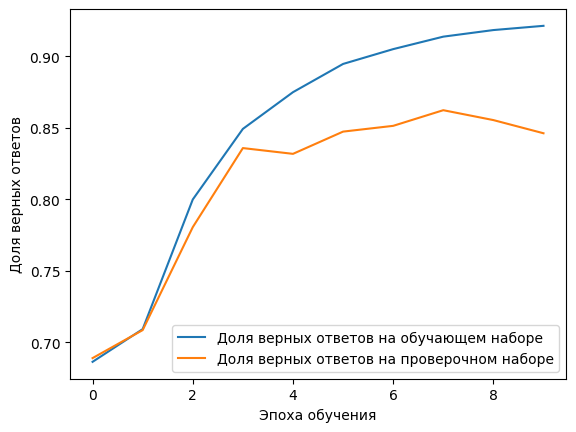

In [24]:
# Обучаем модель
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val, y_val)
                    )

# Визуализируем процесс обучения
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [25]:
# Проверяем работу сети на тестовом наборе данных
scores = model.evaluate(x_test, y_test, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 2))


28/28 [==============================] - 1s 18ms/step - loss: 0.4357 - accuracy: 0.8410
Доля верных ответов на тестовых данных, в процентах: 84.1


In [26]:
y_pred = model.predict(x_test)
y_pred

28/28 [==============================] - 1s 19ms/step


array([[3.78512661e-03, 7.88639951e-03, 9.88328457e-01],
       [9.81036782e-01, 1.80152617e-02, 9.47930210e-04],
       [8.64415944e-01, 1.03337482e-01, 3.22465673e-02],
       ...,
       [7.98064113e-01, 1.14628345e-01, 8.73076022e-02],
       [5.92027754e-02, 8.55776668e-02, 8.55219603e-01],
       [9.03321087e-01, 7.93756843e-02, 1.73032526e-02]], dtype=float32)

In [27]:
# Преобразуем вероятности в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразуем числовые метки обратно в текстовые
mood_map_inv = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_texts = [mood_map_inv[label] for label in y_pred_classes]
y_test_texts = [mood_map_inv[label] for label in y_test]

In [28]:
y_test_texts

['positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'positive',
 'positive',
 'positive',
 'p

In [29]:
# Добавьте предсказания в исходный DataFrame как новый столбец
df_test = pd.DataFrame({
    'Text': texts[-len(x_test):],  # Берем тексты из последней части исходного списка
    'True Label': y_test_texts,
    'Predicted Label': y_pred_texts
})

# Найдите неправильные предсказания
incorrect_df_rnn = df_test[df_test['True Label'] != df_test['Predicted Label']]

# Сохраните DataFrame с неправильными предсказаниями в CSV файл для дальнейшего анализа
incorrect_df_rnn.to_csv('incorrect_predictions.csv', index=False)

In [30]:
incorrect_df_rnn.head()

,Text,True Label,Predicted Label
8,очень хороший👍👍\n,negative,positive
28,неплохой комод. только приходиться сверлить но...,negative,positive
40,отличный!\n,negative,positive
43,все отлично\n,positive,negative
44,"сам комод отличный, вместительный.место много ...",neutral,negative


# LSTM

In [31]:
from tensorflow.keras.layers import LSTM

# Создаем модель нейронной сети
model = Sequential()
model.add(Embedding(max_words, 50, input_length=max_length))  # Увеличим размерность эмбеддинга до 50
model.add(LSTM(64, recurrent_dropout=0.2))  # Увеличим количество нейронов в LSTM до 64 и добавим dropout
model.add(Dense(3, activation='softmax'))  # 3 класса: negative, neutral, positive

# Компилируем модель
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Используем sparse_categorical_crossentropy для многоклассовой классификации
              metrics=['accuracy'])

Слой Embedding:

model.add(Embedding(max_words, 50, input_length=max_length))
Преобразует слова в векторы фиксированной длины. Здесь max_words — размер словаря, 50 — размерность векторов слов (эмбеддингов), а input_length — длина входных последовательностей.

Слой LSTM:

model.add(LSTM(64, recurrent_dropout=0.2))
LSTM слой с 64 нейронами. LSTM предназначен для работы с последовательными данными, такими как текст. Он может запоминать информацию на длительное время и использует recurrent_dropout=0.2 для предотвращения переобучения (регуляризация).

Выходной слой:

model.add(Dense(3, activation='softmax'))
Полносвязный слой с 3 нейронами, где каждый нейрон соответствует одному из классов (negative, neutral, positive). softmax функция активации преобразует выходные значения в вероятности для каждого класса.

Epoch 1/10
48/48 [==============================] - 38s 708ms/step - loss: 0.7980 - accuracy: 0.6965 - val_loss: 0.7111 - val_accuracy: 0.6888
Epoch 2/10
48/48 [==============================] - 32s 671ms/step - loss: 0.5686 - accuracy: 0.7658 - val_loss: 0.4970 - val_accuracy: 0.8311
Epoch 3/10
48/48 [==============================] - 33s 696ms/step - loss: 0.3733 - accuracy: 0.8729 - val_loss: 0.5122 - val_accuracy: 0.8046
Epoch 4/10
48/48 [==============================] - 30s 626ms/step - loss: 0.2962 - accuracy: 0.8986 - val_loss: 0.4242 - val_accuracy: 0.8542
Epoch 5/10
48/48 [==============================] - 31s 634ms/step - loss: 0.2415 - accuracy: 0.9145 - val_loss: 0.4370 - val_accuracy: 0.8530
Epoch 6/10
48/48 [==============================] - 30s 630ms/step - loss: 0.2050 - accuracy: 0.9234 - val_loss: 0.4457 - val_accuracy: 0.8513
Epoch 7/10
48/48 [==============================] - 29s 612ms/step - loss: 0.1716 - accuracy: 0.9336 - val_loss: 0.4824 - val_accuracy: 0.8478

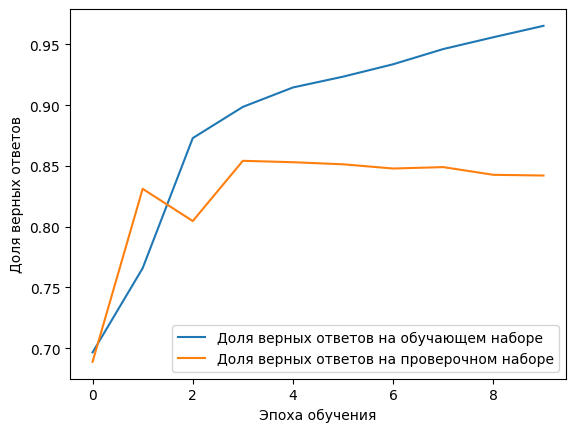

In [32]:
# Обучаем модель
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_val, y_val)
                    )

# Визуализируем процесс обучения
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [33]:
# Проверяем работу сети на тестовом наборе данных
scores = model.evaluate(x_test, y_test, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 2))


28/28 [==============================] - 2s 89ms/step - loss: 0.6097 - accuracy: 0.8410
Доля верных ответов на тестовых данных, в процентах: 84.1


In [34]:
y_pred = model.predict(x_test)
# Преобразуем вероятности в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)
# Преобразуем числовые метки обратно в текстовые
mood_map_inv = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_texts = [mood_map_inv[label] for label in y_pred_classes]
y_test_texts = [mood_map_inv[label] for label in y_test]
# Добавьте предсказания в исходный DataFrame как новый столбец
df_test = pd.DataFrame({
    'Text': texts[-len(x_test):],  # Берем тексты из последней части исходного списка
    'True Label': y_test_texts,
    'Predicted Label': y_pred_texts
})

# Найдите неправильные предсказания
incorrect_df_lstm = df_test[df_test['True Label'] != df_test['Predicted Label']]

# Сохраните DataFrame с неправильными предсказаниями в CSV файл для дальнейшего анализа
incorrect_df_lstm.to_csv('incorrect_predictions.csv', index=False)
incorrect_df_lstm.head()

28/28 [==============================] - 3s 89ms/step


,Text,True Label,Predicted Label
12,"приходить целый, тяжелый\n",negative,neutral
18,"деталь не сходиться в сборка , неправильно быт...",negative,positive
28,неплохой комод. только приходиться сверлить но...,negative,positive
43,все отлично\n,positive,negative
48,"хороший комод, гвоздика и болтик даже с запас ...",positive,negative


#GRU

In [35]:
from tensorflow.keras.layers import GRU


In [36]:
# Создаем модель нейронной сети
model = Sequential()
model.add(Embedding(max_words, 50, input_length=max_length))  # Увеличим размерность эмбеддинга до 50
model.add(GRU(64, recurrent_dropout=0.2))  # Увеличим количество нейронов в GRU до 64 и добавим dropout
model.add(Dense(3, activation='softmax'))  # 3 класса: negative, neutral, positive

# Компилируем модель
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Используем sparse_categorical_crossentropy для многоклассовой классификации
              metrics=['accuracy'])

Epoch 1/20
48/48 [==============================] - 32s 618ms/step - loss: 0.8115 - accuracy: 0.6955 - val_loss: 0.6813 - val_accuracy: 0.6893
Epoch 2/20
48/48 [==============================] - 29s 614ms/step - loss: 0.5449 - accuracy: 0.7682 - val_loss: 0.5151 - val_accuracy: 0.7948
Epoch 3/20
48/48 [==============================] - 33s 673ms/step - loss: 0.3742 - accuracy: 0.8684 - val_loss: 0.4596 - val_accuracy: 0.8363
Epoch 4/20
48/48 [==============================] - 29s 602ms/step - loss: 0.2813 - accuracy: 0.9005 - val_loss: 0.4726 - val_accuracy: 0.8369
Epoch 5/20
48/48 [==============================] - 29s 602ms/step - loss: 0.2432 - accuracy: 0.9124 - val_loss: 0.4760 - val_accuracy: 0.8334
Epoch 6/20
48/48 [==============================] - 28s 593ms/step - loss: 0.1991 - accuracy: 0.9241 - val_loss: 0.5102 - val_accuracy: 0.8380
Epoch 7/20
48/48 [==============================] - 27s 572ms/step - loss: 0.1657 - accuracy: 0.9364 - val_loss: 0.5451 - val_accuracy: 0.8415

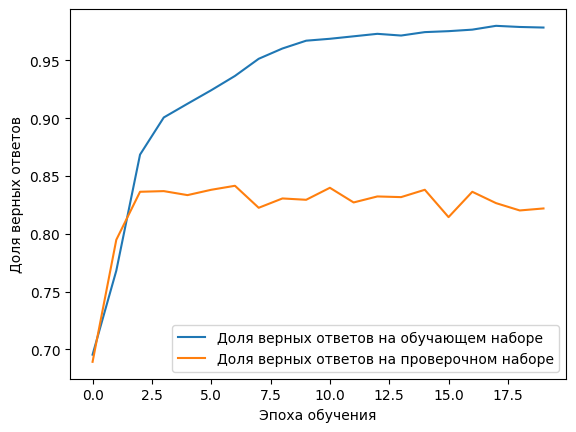

In [37]:
# Обучаем модель
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val))

# Визуализируем процесс обучения
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [38]:
# Проверяем работу сети на тестовом наборе данных
scores = model.evaluate(x_test, y_test, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 2))


28/28 [==============================] - 2s 78ms/step - loss: 0.8915 - accuracy: 0.8157
Доля верных ответов на тестовых данных, в процентах: 81.57


In [39]:
y_pred = model.predict(x_test)
# Преобразуем вероятности в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)
# Преобразуем числовые метки обратно в текстовые
mood_map_inv = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_texts = [mood_map_inv[label] for label in y_pred_classes]
y_test_texts = [mood_map_inv[label] for label in y_test]
# Добавьте предсказания в исходный DataFrame как новый столбец
df_test = pd.DataFrame({
    'Text': texts[-len(x_test):],  # Берем тексты из последней части исходного списка
    'True Label': y_test_texts,
    'Predicted Label': y_pred_texts
})

# Найдите неправильные предсказания
incorrect_df_gru = df_test[df_test['True Label'] != df_test['Predicted Label']]

# Сохраните DataFrame с неправильными предсказаниями в CSV файл для дальнейшего анализа
incorrect_df_gru.to_csv('incorrect_predictions.csv', index=False)
incorrect_df_gru.head()

28/28 [==============================] - 2s 56ms/step


,Text,True Label,Predicted Label
11,нет ключ для сборка и у я тоже нет этот ключ д...,negative,neutral
28,неплохой комод. только приходиться сверлить но...,negative,positive
42,"приходиться много перекручивать , делать сам м...",negative,positive
43,все отлично\n,positive,negative
44,"сам комод отличный, вместительный.место много ...",neutral,positive


#CNN

In [40]:
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten

# Создаем модель нейронной сети
model = Sequential()
model.add(Embedding(max_words, 50, input_length=max_length))  # Увеличим размерность эмбеддинга до 50
model.add(Conv1D(100, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(200, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 класса: negative, neutral, positive

# Компилируем модель
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Используем sparse_categorical_crossentropy для многоклассовой классификации
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 50)           500000    
                                                                 
 conv1d (Conv1D)             (None, 196, 100)          25100     
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 100)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 200)           100200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 47, 200)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9400)             

Epoch 1/10
48/48 [==============================] - 11s 131ms/step - loss: 0.7723 - accuracy: 0.6952 - val_loss: 0.7298 - val_accuracy: 0.6934
Epoch 2/10
48/48 [==============================] - 4s 86ms/step - loss: 0.5155 - accuracy: 0.8009 - val_loss: 0.4380 - val_accuracy: 0.8329
Epoch 3/10
48/48 [==============================] - 5s 95ms/step - loss: 0.3140 - accuracy: 0.8933 - val_loss: 0.4147 - val_accuracy: 0.8599
Epoch 4/10
48/48 [==============================] - 3s 61ms/step - loss: 0.2330 - accuracy: 0.9190 - val_loss: 0.4339 - val_accuracy: 0.8427
Epoch 5/10
48/48 [==============================] - 3s 57ms/step - loss: 0.1817 - accuracy: 0.9343 - val_loss: 0.5239 - val_accuracy: 0.8438
Epoch 6/10
48/48 [==============================] - 2s 37ms/step - loss: 0.1434 - accuracy: 0.9468 - val_loss: 0.6258 - val_accuracy: 0.8144
Epoch 7/10
48/48 [==============================] - 2s 51ms/step - loss: 0.1211 - accuracy: 0.9532 - val_loss: 0.6268 - val_accuracy: 0.8207
Epoch 8/10


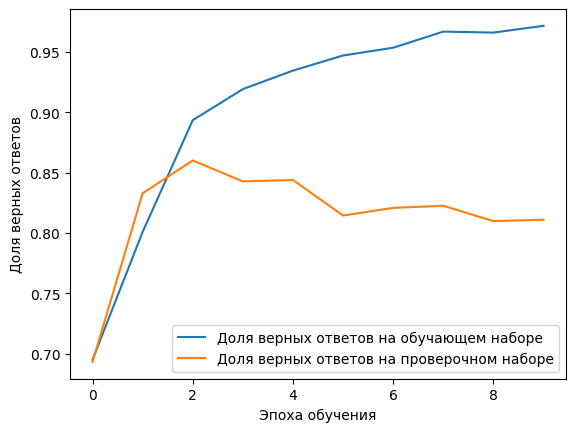

In [41]:
# Обучаем модель
history = model.fit(x_train,
                    y_train,
                    epochs=10,  # Увеличим количество эпох до 10
                    batch_size=128,
                    validation_data=(x_val, y_val))

# Визуализируем процесс обучения
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [42]:
# Проверяем работу сети на тестовом наборе данных
scores = model.evaluate(x_test, y_test, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 2))


28/28 [==============================] - 1s 9ms/step - loss: 0.7664 - accuracy: 0.7949
Доля верных ответов на тестовых данных, в процентах: 79.49


In [43]:
y_pred = model.predict(x_test)
# Преобразуем вероятности в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)
# Преобразуем числовые метки обратно в текстовые
mood_map_inv = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_texts = [mood_map_inv[label] for label in y_pred_classes]
y_test_texts = [mood_map_inv[label] for label in y_test]
# Добавьте предсказания в исходный DataFrame как новый столбец
df_test = pd.DataFrame({
    'Text': texts[-len(x_test):],  # Берем тексты из последней части исходного списка
    'True Label': y_test_texts,
    'Predicted Label': y_pred_texts
})

# Найдите неправильные предсказания
incorrect_df_cnn = df_test[df_test['True Label'] != df_test['Predicted Label']]

# Сохраните DataFrame с неправильными предсказаниями в CSV файл для дальнейшего анализа
incorrect_df_cnn.to_csv('incorrect_predictions.csv', index=False)
incorrect_df_cnn.head()

28/28 [==============================] - 0s 2ms/step


,Text,True Label,Predicted Label
18,"деталь не сходиться в сборка , неправильно быт...",negative,neutral
27,"все целое, единственный недочет, внутренний по...",positive,neutral
28,неплохой комод. только приходиться сверлить но...,negative,positive
40,отличный!\n,negative,neutral
42,"приходиться много перекручивать , делать сам м...",negative,neutral


#CNN 2

In [44]:
from tensorflow.keras.layers import Dense, Embedding, Conv1D, Dropout, GlobalMaxPooling1D

# Создаем модель нейронной сети
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_length))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # 3 класса: negative, neutral, positive

# Компилируем модель
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Используем sparse_categorical_crossentropy для многоклассовой классификации
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 64)           640000    
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 250)          80250     
                                                                 
 global_max_pooling1d (Glob  (None, 250)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_11 (Dense)            (None, 128)               32128     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 3)                 387       
                                                      

Epoch 1/10
48/48 [==============================] - 10s 185ms/step - loss: 0.7624 - accuracy: 0.6967 - val_loss: 0.6031 - val_accuracy: 0.7020
Epoch 2/10
48/48 [==============================] - 7s 144ms/step - loss: 0.4400 - accuracy: 0.8426 - val_loss: 0.4091 - val_accuracy: 0.8559
Epoch 3/10
48/48 [==============================] - 6s 126ms/step - loss: 0.3026 - accuracy: 0.8996 - val_loss: 0.3998 - val_accuracy: 0.8651
Epoch 4/10
48/48 [==============================] - 6s 124ms/step - loss: 0.2237 - accuracy: 0.9188 - val_loss: 0.4159 - val_accuracy: 0.8651
Epoch 5/10
48/48 [==============================] - 6s 117ms/step - loss: 0.1755 - accuracy: 0.9323 - val_loss: 0.4362 - val_accuracy: 0.8611
Epoch 6/10
48/48 [==============================] - 3s 67ms/step - loss: 0.1400 - accuracy: 0.9503 - val_loss: 0.5105 - val_accuracy: 0.8507
Epoch 7/10
48/48 [==============================] - 3s 73ms/step - loss: 0.1070 - accuracy: 0.9643 - val_loss: 0.5409 - val_accuracy: 0.8380
Epoch 8

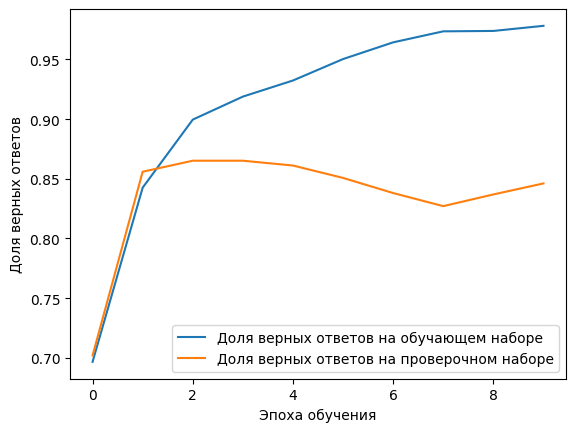

In [45]:
# Обучаем модель
history = model.fit(x_train,
                    y_train,
                    epochs=10,  # Увеличим количество эпох до 10
                    batch_size=128,
                    validation_data=(x_val, y_val)
                    )

# Визуализируем процесс обучения
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [46]:
# Проверяем работу сети на тестовом наборе данных
scores = model.evaluate(x_test, y_test, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 2))


28/28 [==============================] - 1s 36ms/step - loss: 0.6572 - accuracy: 0.8399
Доля верных ответов на тестовых данных, в процентах: 83.99


In [47]:
y_pred = model.predict(x_test)
# Преобразуем вероятности в метки классов
y_pred_classes = np.argmax(y_pred, axis=1)
# Преобразуем числовые метки обратно в текстовые
mood_map_inv = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_texts = [mood_map_inv[label] for label in y_pred_classes]
y_test_texts = [mood_map_inv[label] for label in y_test]
# Добавьте предсказания в исходный DataFrame как новый столбец
df_test = pd.DataFrame({
    'Text': texts[-len(x_test):],  # Берем тексты из последней части исходного списка
    'True Label': y_test_texts,
    'Predicted Label': y_pred_texts
})

# Найдите неправильные предсказания
incorrect_df_cnn2 = df_test[df_test['True Label'] != df_test['Predicted Label']]

# Сохраните DataFrame с неправильными предсказаниями в CSV файл для дальнейшего анализа
incorrect_df_cnn2.to_csv('incorrect_predictions.csv', index=False)
incorrect_df_cnn2.head()

28/28 [==============================] - 0s 2ms/step


,Text,True Label,Predicted Label
18,"деталь не сходиться в сборка , неправильно быт...",negative,positive
28,неплохой комод. только приходиться сверлить но...,negative,positive
40,отличный!\n,negative,positive
42,"приходиться много перекручивать , делать сам м...",negative,positive
43,все отлично\n,positive,negative


In [ ]:
incorrect_df_gru.head()

In [ ]:
import pandas as pd


# Начнем с объединения двух датафреймов и будем добавлять по одному
merged_df = incorrect_df_gru.merge(incorrect_df_cnn2, on='Index', how='inner', suffixes=('_gru', '_cnn2'))
merged_df = merged_df.merge(incorrect_df_cnn, on='Index', how='inner', suffixes=('', '_cnn'))
merged_df = merged_df.merge(incorrect_df_lstm, on='Index', how='inner', suffixes=('', '_lstm'))
merged_df = merged_df.merge(incorrect_df_rnn, on='Index', how='inner', suffixes=('', '_rnn'))
merged_df = merged_df.merge(incorrect_df_fcnn, on='Index', how='inner', suffixes=('', '_fcnn'))

# Опционально: удаление дублирующихся столбцов, если они появились после объединения
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Посмотрим на объединенный датафрейм
merged_df.head()


In [ ]:
# Получение пересечения индексов
common_indices = set(incorrect_df_gru['Index'])
for df in [incorrect_df_cnn2, incorrect_df_cnn, incorrect_df_lstm, incorrect_df_rnn, incorrect_df_fcnn]:
    common_indices &= set(df['Index'])

# Фильтрация датафреймов по общим индексам
filtered_dfs = []
for df in [incorrect_df_gru, incorrect_df_cnn2, incorrect_df_cnn, incorrect_df_lstm, incorrect_df_rnn, incorrect_df_fcnn]:
    filtered_dfs.append(df[df['Index'].isin(common_indices)])

# Слияние датафреймов по индексу
merged_df = filtered_dfs[0]
for df in filtered_dfs[1:]:
    merged_df = merged_df.merge(df, on=['Text', 'True Label', 'Predicted Label', 'Index'])

# Вывод результата
merged_df.shape

In [ ]:
merged_df